In [1]:
# Import the required modules
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import MultiplierGate, RGQFTMultiplier, ModularAdderGate
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
import numpy as np

import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
from quantumrings.toolkit.qiskit import QrJobV1

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
QR_TOKEN = os.getenv("QR_TOKEN")
QR_NAME = os.getenv("QR_NAME")

In [3]:
QR_TOKEN, QR_NAME

('rings-200.GEff3TcwVen6gCRnoxylxs5E0ifR5JxP', 'hd7556@princeton.edu')

In [4]:
# Acquire the Quantum Rings Provider
qr_provider = QuantumRingsProvider(token=QR_TOKEN, name=QR_NAME)

In [5]:
# controlled multipliers
def exponent(base, power, num_state_qubits):
    exp_gate = QuantumCircuit(2 * num_state_qubits)
    for i in range(base ** power):
        exp_gate.append(ModularAdderGate(num_state_qubits=num_state_qubits), range(2 * num_state_qubits))
    return exp_gate.to_gate().control(1)

In [6]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cp(-np.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return

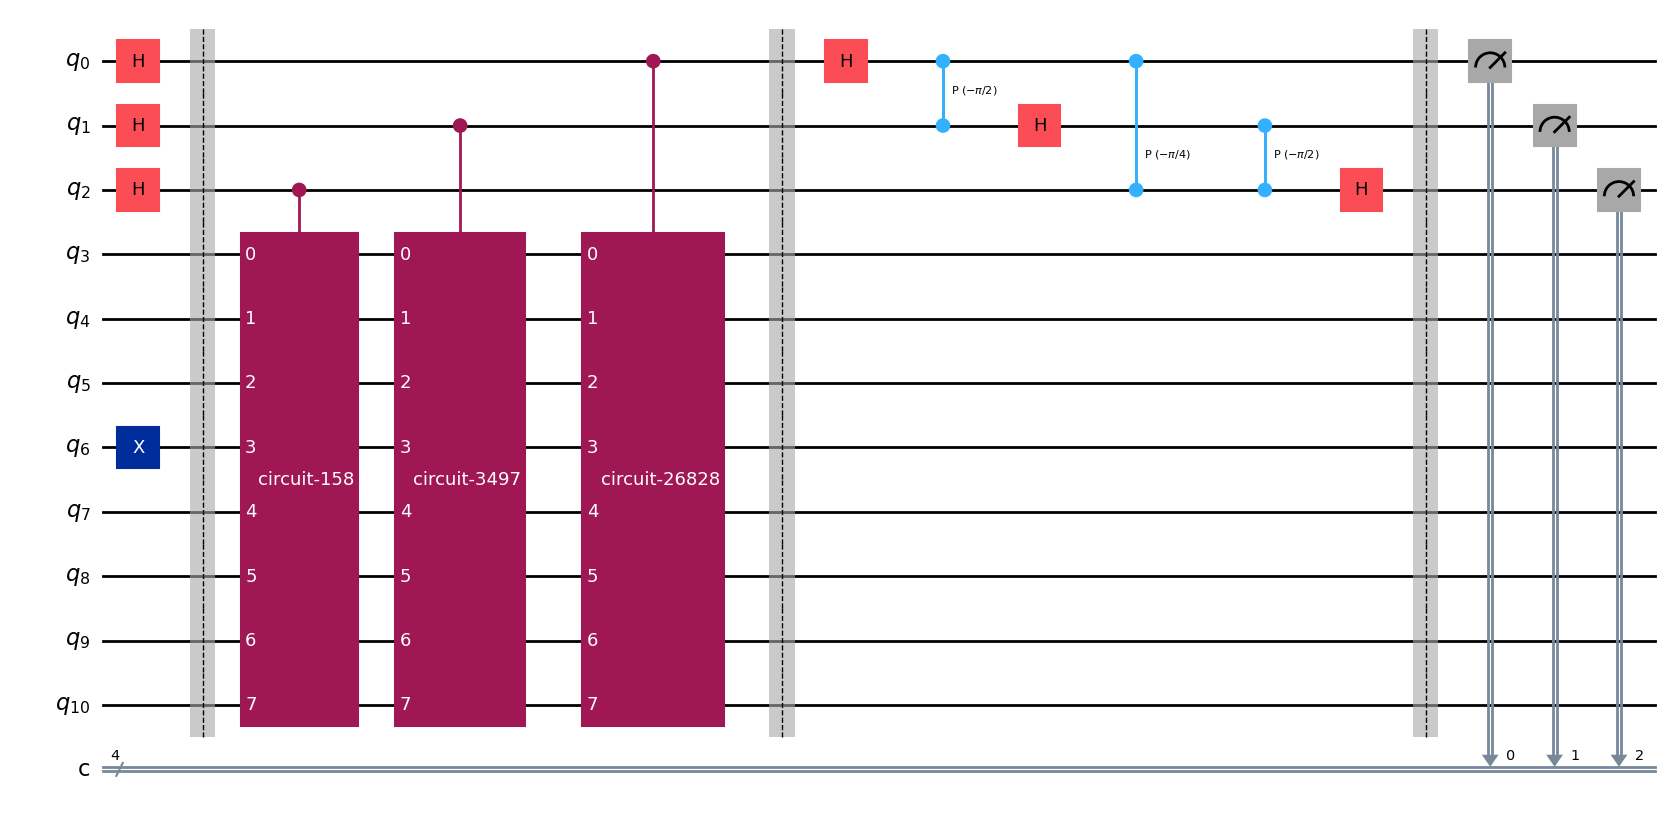

In [7]:
num_size = 4
q = QuantumRegister(2 * num_size + 3, 'q')
c = ClassicalRegister(4 , 'c')
qc = QuantumCircuit(q, c)

# hadamard gates
qc.h(0)
qc.h(1)
qc.h(2)

# g_num = 3, start_num = 5
qc.x(6)
qc.draw(output="mpl")

qc.barrier()

# controlled multipliers
for power in range(2, num_size + 1):
    qc.append(exponent(7, power, num_size), [4 - power] + list(range(3, qc.num_qubits)) )

qc.barrier()

iqft_cct(qc, q, 3)

# measure target qubits
qc.measure(range(3), range(3))

qc.draw(output="mpl")

In [8]:
# transpile circuit to Quantum Rings backend
qr_backend = QrBackendV2(qr_provider, num_qubits = qc.num_qubits)
qc_transpiled = transpile(qc, qr_backend, initial_layout=[i for i in range(0, qc.num_qubits)])

In [ ]:
# Execute the quantum code
job = qr_backend.run(qc_transpiled, shots = 1024)

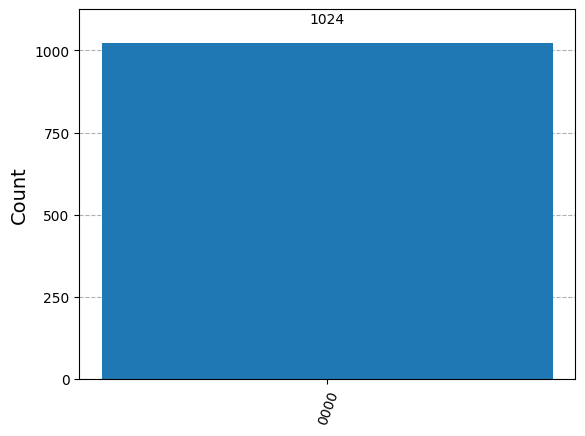

In [ ]:
result = job.result()
counts = result.get_counts()
plot_histogram(counts)